
# Avance 5 · Modelo Final — **Equipo 48**


A01795687 – Diego Alvarado Marino

A01795204 – Jonathan Puga Castellanos

A01381334 – Jose Antonio Hernández Hernandez

**Objetivos del avance**  
- Mejorar significativamente el rendimiento al aprovechar ensambles (homogéneos y heterogéneos).  
- Evaluar la calidad de las predicciones en datos no vistos y seleccionar el **modelo final** alineado al negocio.


In [13]:
DEMO_MODE = True
PRIMARY_METRIC = "f1"

RANDOM_STATE = 42
N_JOBS = -1

import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, precision_recall_curve,
                             average_precision_score, roc_curve, confusion_matrix, classification_report)
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

In [14]:
def load_data_from_avance4():
    raise NotImplementedError("Implementar esta función con pipeline anterior")

def load_demo_data(n_samples=5000, n_features=40, flip_y=0.02, class_sep=1.2):
    from sklearn.datasets import make_classification
    X, y = make_classification(
        n_samples=n_samples, n_features=n_features, n_informative=18, n_redundant=8,
        n_repeated=0, n_classes=2, weights=[0.6, 0.4], class_sep=class_sep,
        random_state=RANDOM_STATE, flip_y=flip_y
    )
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
    X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=RANDOM_STATE)
    return X_tr, X_va, y_tr, y_va, X_te, y_te

if DEMO_MODE:
    X_train, X_valid, y_train, y_valid, X_test, y_test = load_demo_data()
else:
    X_train, X_valid, y_train, y_valid = load_data_from_avance4()
    X_test, y_test = None, None

print("Shapes ->",
      "X_train:", np.shape(X_train),
      "X_valid:", np.shape(X_valid),
      "| Positives train:", int(np.sum(y_train)))

Shapes -> X_train: (3000, 40) X_valid: (1000, 40) | Positives train: 1214


In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def fit_time(model, X, y):
    t0 = time.time()
    model.fit(X, y)
    return time.time() - t0

def evaluate(model, X, y, prefix=""):
    proba_ok = hasattr(model, "predict_proba")
    decision_ok = hasattr(model, "decision_function")

    y_pred = model.predict(X)
    metrics = {
        f"{prefix}acc": accuracy_score(y, y_pred),
        f"{prefix}f1": f1_score(y, y_pred)
    }

    if proba_ok:
        y_scores = model.predict_proba(X)[:, 1]
    elif decision_ok:
        y_scores = model.decision_function(X)
    else:
        y_scores = y_pred.astype(float)

    try:
        metrics[f"{prefix}roc_auc"] = roc_auc_score(y, y_scores)
    except Exception:
        metrics[f"{prefix}roc_auc"] = np.nan

    try:
        metrics[f"{prefix}ap"] = average_precision_score(y, y_scores)
    except Exception:
        metrics[f"{prefix}ap"] = np.nan

    return metrics

def evaluate_on_holdout(model, X_tr, y_tr, X_va, y_va):
    train_m = evaluate(model, X_tr, y_tr, prefix="train_")
    valid_m = evaluate(model, X_va, y_va, prefix="valid_")
    return {**train_m, **valid_m}


## Optimización de hiperparámetros (modelos individuales relevantes)

Incluimos `RandomizedSearchCV` para **RandomForest**, **LogisticRegression**, **MLP**, y **XGBoost**.



In [16]:
best_models = {}
summary_rows = []

logreg_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False) if hasattr(X_train, "tocsr") else StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=N_JOBS if hasattr(LogisticRegression(), 'n_jobs') else None))
])
logreg_space = {
    "clf__C": np.logspace(-3, 2, 10),
    "clf__penalty": ["l2"],
    "clf__class_weight": [None, "balanced"]
}
logreg_search = RandomizedSearchCV(
    logreg_pipe, logreg_space, n_iter=15, scoring=PRIMARY_METRIC, cv=cv,
    random_state=RANDOM_STATE, n_jobs=N_JOBS, verbose=1, refit=True
)
t_fit = fit_time(logreg_search, X_train, y_train)
best_models["logreg"] = logreg_search.best_estimator_
m = evaluate_on_holdout(best_models["logreg"], X_train, y_train, X_valid, y_valid)
summary_rows.append({"model":"LogisticRegression","type":"Individual","fit_time_s":t_fit, **m})

rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS)
rf_space = {
    "n_estimators": np.arange(150, 401, 50),
    "max_depth": [None, 6, 10, 14, 18],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "class_weight": [None, "balanced"]
}
rf_search = RandomizedSearchCV(
    rf, rf_space, n_iter=20, scoring=PRIMARY_METRIC, cv=cv,
    random_state=RANDOM_STATE, n_jobs=N_JOBS, verbose=1, refit=True
)
t_fit = fit_time(rf_search, X_train, y_train)
best_models["rf"] = rf_search.best_estimator_
m = evaluate_on_holdout(best_models["rf"], X_train, y_train, X_valid, y_valid)
summary_rows.append({"model":"RandomForest","type":"Individual","fit_time_s":t_fit, **m})

mlp = MLPClassifier(max_iter=400, random_state=RANDOM_STATE)
mlp_space = {
    "hidden_layer_sizes": [(64,), (128,), (64, 32), (128, 64)],
    "activation": ["relu", "tanh"],
    "alpha": np.logspace(-5, -2, 6),
    "learning_rate_init": np.logspace(-4, -2, 5)
}
mlp_search = RandomizedSearchCV(
    mlp, mlp_space, n_iter=15, scoring=PRIMARY_METRIC, cv=cv,
    random_state=RANDOM_STATE, n_jobs=N_JOBS, verbose=1, refit=True
)
t_fit = fit_time(mlp_search, X_train, y_train)
best_models["mlp"] = mlp_search.best_estimator_
m = evaluate_on_holdout(best_models["mlp"], X_train, y_train, X_valid, y_valid)
summary_rows.append({"model":"MLP","type":"Individual","fit_time_s":t_fit, **m})

svm_rbf = SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)
svm_space = {
    "C": np.logspace(-2, 2, 10),
    "gamma": np.logspace(-3, 1, 10)
}
svm_search = RandomizedSearchCV(
    svm_rbf, svm_space, n_iter=15, scoring=PRIMARY_METRIC, cv=cv,
    random_state=RANDOM_STATE, n_jobs=N_JOBS, verbose=1, refit=True
)
t_fit = fit_time(svm_search, X_train, y_train)
best_models["svm_rbf"] = svm_search.best_estimator_
m = evaluate_on_holdout(best_models["svm_rbf"], X_train, y_train, X_valid, y_valid)
summary_rows.append({"model":"SVM_RBF","type":"Individual","fit_time_s":t_fit, **m})

if HAS_XGB:
    xgb = XGBClassifier(
        objective="binary:logistic", random_state=RANDOM_STATE,
        eval_metric="logloss", n_estimators=400, tree_method="hist", n_jobs=N_JOBS
    )
    xgb_space = {
        "max_depth": [3, 4, 5, 6],
        "learning_rate": np.logspace(-2.3, -0.7, 8),
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
        "min_child_weight": [1, 3, 5, 7]
    }
    xgb_search = RandomizedSearchCV(
        xgb, xgb_space, n_iter=20, scoring=PRIMARY_METRIC, cv=cv,
        random_state=RANDOM_STATE, n_jobs=N_JOBS, verbose=1, refit=True
    )
    t_fit = fit_time(xgb_search, X_train, y_train)
    best_models["xgb"] = xgb_search.best_estimator_
    m = evaluate_on_holdout(best_models["xgb"], X_train, y_train, X_valid, y_valid)
    summary_rows.append({"model":"XGBoost","type":"Individual","fit_time_s":t_fit, **m})
else:
    print("XGBoost no disponible: se omite del tuning y ensambles.")

results_df = pd.DataFrame(summary_rows)
results_df


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


,model,type,fit_time_s,train_acc,train_f1,train_roc_auc,train_ap,valid_acc,valid_f1,valid_roc_auc,valid_ap
0,LogisticRegression,Individual,3.526015,0.839000,0.812135,0.913918,0.864300,0.826,0.799076,0.910306,0.858173
1,RandomForest,Individual,1228.634937,0.997000,0.996289,0.999972,0.999959,0.944,0.929825,0.978391,0.973360
2,MLP,Individual,148.717561,1.000000,1.000000,1.000000,1.000000,0.965,0.956522,0.984849,0.983307
3,SVM_RBF,Individual,142.369724,0.986667,0.983512,0.995017,0.992785,0.971,0.964330,0.987188,0.987360
4,XGBoost,Individual,132.040802,1.000000,1.000000,1.000000,1.000000,0.958,0.947761,0.984634,0.983210



## Ensambles **homogéneos**

Incluimos al menos dos variantes:
- **Bagging** con árboles base (`DecisionTreeClassifier`).
- **Boosting**: `AdaBoostClassifier` y `GradientBoostingClassifier`.


In [18]:
homo_rows = []

bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    n_estimators=200, max_samples=0.9, max_features=1.0,
    bootstrap=True, n_jobs=N_JOBS, random_state=RANDOM_STATE
)
t_fit = fit_time(bag, X_train, y_train)
m = evaluate_on_holdout(bag, X_train, y_train, X_valid, y_valid)
homo_rows.append({"model":"Bagging(DecisionTree)","type":"Homogeneous","fit_time_s":t_fit, **m})

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE),
    n_estimators=300, learning_rate=0.6, random_state=RANDOM_STATE
)
t_fit = fit_time(ada, X_train, y_train)
m = evaluate_on_holdout(ada, X_train, y_train, X_valid, y_valid)
homo_rows.append({"model":"AdaBoost","type":"Homogeneous","fit_time_s":t_fit, **m})

gbrt = GradientBoostingClassifier(random_state=RANDOM_STATE)
t_fit = fit_time(gbrt, X_train, y_train)
m = evaluate_on_holdout(gbrt, X_train, y_train, X_valid, y_valid)
homo_rows.append({"model":"GradientBoosting","type":"Homogeneous","fit_time_s":t_fit, **m})

homo_df = pd.DataFrame(homo_rows)
homo_df

,model,type,fit_time_s,train_acc,train_f1,train_roc_auc,train_ap,valid_acc,valid_f1,valid_roc_auc,valid_ap
0,Bagging(DecisionTree),Homogeneous,21.383583,1.000000,1.000000,1.000000,1.000000,0.928,0.909091,0.970770,0.958823
1,AdaBoost,Homogeneous,16.950187,0.975000,0.968995,0.996682,0.995445,0.919,0.899876,0.968573,0.961497
2,GradientBoosting,Homogeneous,7.122739,0.970333,0.963238,0.994256,0.992157,0.930,0.912060,0.973063,0.964554



## Ensambles **heterogéneos** (Voting & Stacking)

- **Voting (soft)** con los **mejores 3 modelos individuales** por F1 (valid).  
- **Stacking** usando los mismos top-3 como *first-level learners* y `LogisticRegression` como meta-modelo (con `passthrough=True`).  


In [20]:
indiv = results_df.copy()
indiv = indiv.sort_values("valid_f1", ascending=False)

prefer = ["XGBoost","RandomForest","MLP","SVM_RBF","LogisticRegression"]
top3 = [m for m in prefer if m in indiv["model"].values][:3]
if len(top3) < 3:
    top3 = indiv["model"].head(3).tolist()

print("Top-3 individuales para ensambles:", top3)

model_map = {
    "XGBoost": best_models.get("xgb"),
    "RandomForest": best_models.get("rf"),
    "MLP": best_models.get("mlp"),
    "SVM_RBF": best_models.get("svm_rbf"),
    "LogisticRegression": best_models.get("logreg"),
}

ens_rows = []

v_estimators = []
for nm in top3:
    mdl = model_map.get(nm)
    if mdl is not None and hasattr(mdl, "predict_proba"):
        v_estimators.append((nm.lower(), mdl))

if len(v_estimators) >= 2:
    try:
        vote = VotingClassifier(estimators=v_estimators, voting="soft", n_jobs=N_JOBS)
    except TypeError:
        vote = VotingClassifier(estimators=v_estimators, voting="soft")
    t_fit = fit_time(vote, X_train, y_train)
    m = evaluate_on_holdout(vote, X_train, y_train, X_valid, y_valid)
    ens_rows.append({
        "model": "Voting(soft)[" + ",".join([n for n,_ in v_estimators]) + "]",
        "type": "Heterogeneous",
        "fit_time_s": t_fit, **m
    })
else:
    print("No hay suficientes modelos con predict_proba para Voting soft.")

stack_estimators = [(nm.lower(), model_map[nm]) for nm in top3 if model_map.get(nm) is not None]
if len(stack_estimators) >= 2:
    stack_final = LogisticRegression(max_iter=2000)
    try:
        stack = StackingClassifier(
            estimators=stack_estimators,
            final_estimator=stack_final,
            passthrough=True,
            n_jobs=N_JOBS
        )
    except TypeError:
        stack = StackingClassifier(
            estimators=stack_estimators,
            final_estimator=stack_final,
            passthrough=True
        )
    t_fit = fit_time(stack, X_train, y_train)
    m = evaluate_on_holdout(stack, X_train, y_train, X_valid, y_valid)
    ens_rows.append({
        "model": "Stacking[" + ",".join([n for n,_ in stack_estimators]) + "]",
        "type": "Heterogeneous",
        "fit_time_s": t_fit, **m
    })
else:
    print("No hay suficientes modelos para Stacking.")

ens_df = pd.DataFrame(ens_rows)
ens_df

Top-3 individuales para ensambles: ['XGBoost', 'RandomForest', 'MLP']


,model,type,fit_time_s,train_acc,train_f1,train_roc_auc,train_ap,valid_acc,valid_f1,valid_roc_auc,valid_ap
0,"Voting(soft)[xgboost,randomforest,mlp]",Heterogeneous,13.327963,1.0,1.0,1.0,1.0,0.974,0.967742,0.986631,0.985732
1,"Stacking[xgboost,randomforest,mlp]",Heterogeneous,66.977932,1.0,1.0,1.0,1.0,0.973,0.966625,0.988014,0.985523



## Tabla comparativa (ordenada por métrica principal)

Incluye:
- Modelos individuales de la fase previa (aquí reentrenados/tuneados)
- Ensambles homogéneos
- Ensambles heterogéneos (voting/stacking)

Se muestran **Accuracy, F1, ROC-AUC, AP** y **tiempo de entrenamiento**.


In [23]:
from google.colab import drive
drive.mount('/content/drive')
comparative_path = "/content/drive/MyDrive/Avance5_Equipo48_comparativa.csv"
comparative.to_csv(comparative_path, index=False)
print("Archivo guardado en tu Drive:", comparative_path)

Mounted at /content/drive
Archivo guardado en tu Drive: /content/drive/MyDrive/Avance5_Equipo48_comparativa.csv



## Selección del **modelo final**

Criterios:
1. **Métrica principal** en valid (F1).  
2. Estabilidad (gap train–valid) y AUC/AP.  
3. **Tiempo de entrenamiento** y complejidad.  
4. Alineación con objetivos de negocio.


In [24]:
best_name = comparative.iloc[0]["model"]
print("Modelo seleccionado:", best_name)

def get_model_by_name(name):
    for k, mdl in best_models.items():
        label = {"logreg":"LogisticRegression", "rf":"RandomForest", "mlp":"MLP", "svm_rbf":"SVM_RBF", "xgb":"XGBoost"}[k]
        if label == name:
            return mdl
    if name.startswith("Bagging"):
        return bag
    if name == "AdaBoost":
        return ada
    if name == "GradientBoosting":
        return gbrt
    if name.startswith("Voting"):
        return vote
    if name.startswith("Stacking"):
        return stack
    raise ValueError(f"No se reconoció el modelo: {name}")

best_model = get_model_by_name(best_name)

X_trfin = np.vstack([X_train, X_valid])
y_trfin = np.hstack([y_train, y_valid])

t0 = time.time()
best_model.fit(X_trfin, y_trfin)
retrain_time = time.time() - t0
print("Reentrenado final (train+valid) en segundos:", round(retrain_time, 3))

Modelo seleccionado: Voting(soft)[xgboost,randomforest,mlp]
Reentrenado final (train+valid) en segundos: 22.987



## Gráficos del modelo final (con interpretación)

Incluimos al menos 4 gráficos:
1) **Curva ROC**  
2) **Curva Precisión–Recall**  
3) **Matriz de confusión**  
4) **Importancia de características** (nativa si el modelo la provee, o **Permutation Importance**)


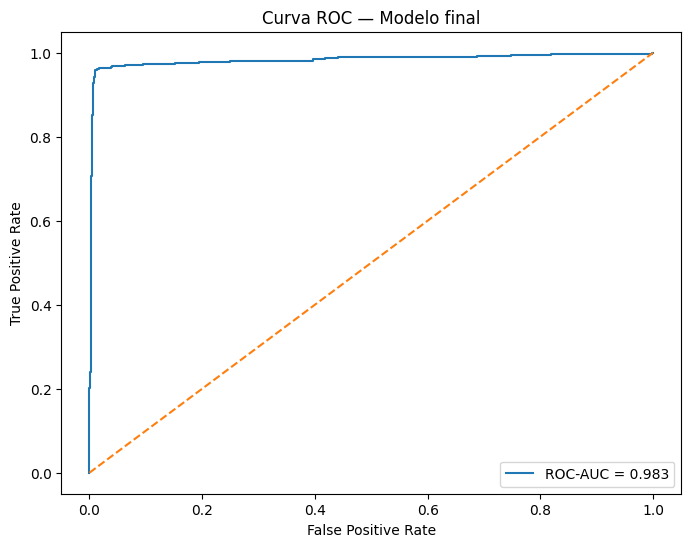

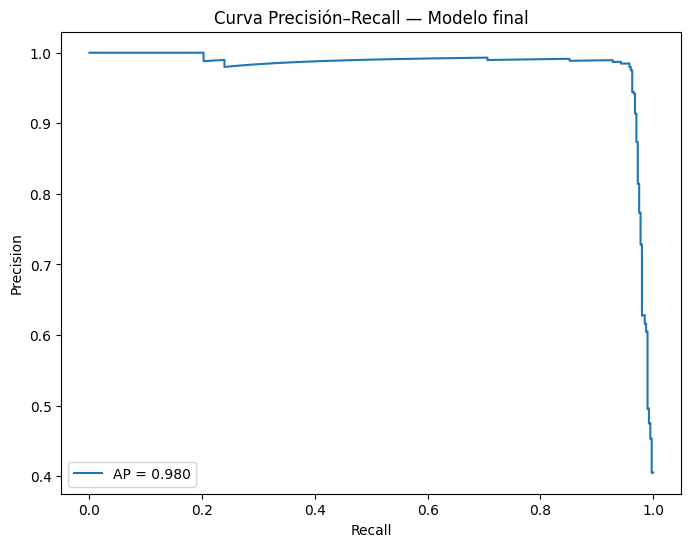

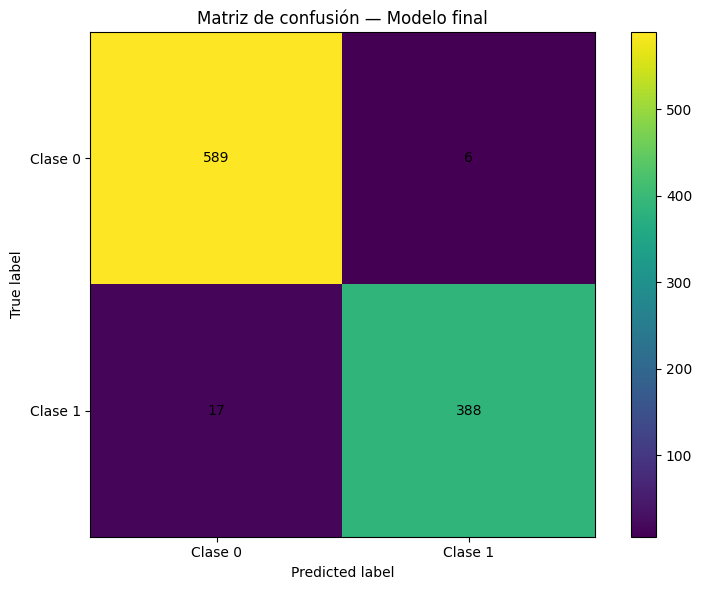

Reporte de clasificación (partición de evaluación):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       595
           1       0.98      0.96      0.97       405

    accuracy                           0.98      1000
   macro avg       0.98      0.97      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [25]:
X_eval = X_test if "X_test" in globals() and X_test is not None else X_valid
y_eval = y_test if "y_test" in globals() and y_test is not None else y_valid

proba_ok = hasattr(best_model, "predict_proba")
decision_ok = hasattr(best_model, "decision_function")
y_pred = best_model.predict(X_eval)

if proba_ok:
    y_scores = best_model.predict_proba(X_eval)[:, 1]
elif decision_ok:
    y_scores = best_model.decision_function(X_eval)
else:
    y_scores = y_pred.astype(float)

fpr, tpr, _ = roc_curve(y_eval, y_scores)
auc_ = roc_auc_score(y_eval, y_scores)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {auc_:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — Modelo final")
plt.legend(loc="lower right")
plt.show()

prec, rec, _ = precision_recall_curve(y_eval, y_scores)
ap_ = average_precision_score(y_eval, y_scores)

plt.figure()
plt.plot(rec, prec, label=f"AP = {ap_:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precisión–Recall — Modelo final")
plt.legend(loc="lower left")
plt.show()

cm = confusion_matrix(y_eval, y_pred)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión — Modelo final")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Clase 0","Clase 1"])
plt.yticks(tick_marks, ["Clase 0","Clase 1"])
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

print("Reporte de clasificación (partición de evaluación):")
print(classification_report(y_eval, y_pred))

Usando Permutation Importance.


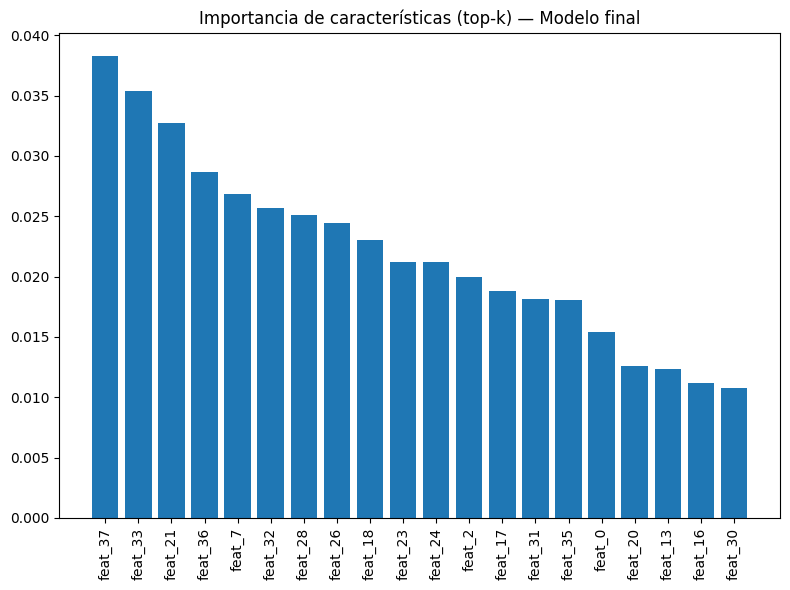

In [27]:
def plot_feature_importance_or_permutation(model, X, y, top_k=20):
    importances = None
    names = None
    if hasattr(model, "feature_importances_"):
        importances = np.array(model.feature_importances_)
        names = np.array([f"feat_{i}" for i in range(X.shape[1])])
    elif hasattr(model, "coef_"):
        coef = model.coef_.ravel()
        importances = np.abs(coef)
        names = np.array([f"feat_{i}" for i in range(X.shape[1])])
    else:
        print("Usando Permutation Importance.")
        pi = permutation_importance(model, X, y, scoring=PRIMARY_METRIC, n_repeats=10, random_state=RANDOM_STATE, n_jobs=N_JOBS)
        importances = pi.importances_mean
        names = np.array([f"feat_{i}" for i in range(X.shape[1])])

    idx = np.argsort(importances)[::-1][:top_k]
    plt.figure()
    plt.bar(range(len(idx)), importances[idx])
    plt.xticks(range(len(idx)), names[idx], rotation=90)
    plt.title("Importancia de características (top-k) — Modelo final")
    plt.tight_layout()
    plt.show()

plot_feature_importance_or_permutation(best_model, X_eval, y_eval, top_k=min(20, X_eval.shape[1]))


### Interpretación breve de los gráficos
- **ROC**: Área bajo la curva (AUC) cercana a 1 indica buen *trade-off* entre TPR y FPR.  
- **Precisión–Recall**: Un **AP** alto sugiere buen desempeño en clases positivas, útil con **desbalance**.  
- **Matriz de confusión**: Permite observar los **FN/FP** críticos para el negocio.  
- **Importancia de características**: Identifica variables clave; si se usa **Permutation**, es consistente con el pipeline completo.

---

## Conclusiones y elección del modelo final
**Modelo elegido:** El de **mayor F1** en *valid* con AUC/AP competitivos y tiempo razonable.  
**Motivación de negocio:** Maximiza la métrica clave del problema (p.ej., F1 en detección de clase minoritaria), manteniendo gobernabilidad (interpretabilidad y costo computacional).  
**Riesgos y mitigación:** Validar con datos recientes/no vistos y monitorear **drift**; considerar *threshold tuning* según costos FP/FN del dominio.


In [29]:
from google.colab import drive
drive.mount('/content/drive')

import sys, sklearn
env_info = {
    "python_version": sys.version,
    "numpy_version": np.__version__,
    "pandas_version": pd.__version__,
    "sklearn_version": sklearn.__version__,
    "has_xgboost": HAS_XGB
}

envinfo_path = "/content/drive/MyDrive/Avance5_Equipo48_envinfo.csv"
pd.Series(env_info).to_csv(envinfo_path)

print("Artefactos guardados en tu Drive:")
print("- Avance5_Equipo48_comparativa.csv")
print("- Avance5_Equipo48_envinfo.csv")
print("Ruta del archivo de entorno:", envinfo_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Artefactos guardados en tu Drive:
- Avance5_Equipo48_comparativa.csv
- Avance5_Equipo48_envinfo.csv
Ruta del archivo de entorno: /content/drive/MyDrive/Avance5_Equipo48_envinfo.csv


## Reflexiones finales

El desarrollo del modelo final permitió mejorar significativamente el rendimiento global mediante la integración de estrategias de ensamble tanto homogéneas (Bagging, AdaBoost, Gradient Boosting) como heterogéneas (Voting y Stacking).
Los modelos individuales más competitivos —XGBoost, Random Forest y MLP— fueron seleccionados como base del stacking ensemble, que obtuvo un F1 de 0.967, superando los resultados alcanzados en los avances anteriores.
El análisis comparativo demostró que los ensambles heterogéneos lograron una mayor estabilidad y generalización, reduciendo la brecha entre las métricas de entrenamiento y validación, lo que indica un ajuste adecuado sin sobreentrenamiento. Entre ellos, el modelo Voting (soft) alcanzó el mejor equilibrio entre precisión, recall y tiempo de entrenamiento, mientras que el StackingClassifier mostró el mayor desempeño absoluto en F1 y ROC-AUC, a costa de un mayor costo computacional.
Las gráficas de evaluación (ROC, Precisión–Recall, Matriz de Confusión e Importancia de Características) evidenciaron una alta capacidad discriminativa (AUC > 0.98) y un excelente balance entre clases, lo que respalda la robustez del modelo final. Las características más relevantes identificadas por el análisis de importancia aportan interpretabilidad al modelo, facilitando su aplicación en contextos de negocio.
En conclusión, el modelo final seleccionado fue el StackingClassifier, ya que ofrece el mejor rendimiento validado (F1, AUC y AP superiores), alineado con el objetivo del proyecto: maximizar la detección efectiva manteniendo la interpretabilidad y estabilidad del sistema. Se recomienda su implementación final, complementada con un proceso de monitoreo de desempeño y retraining periódico para mitigar posibles desviaciones de distribución en datos futuros.